# Deep into Computer Science Publications - Milestone 3
**Applied Data Analysis @ EPFL -** By Nour Ghalia Abbassi, Khalil Cherif, and Aymen Gannouni

# Project Description
Please refer to the following __[readme](https://github.com/aymengan/ADA2017/tree/master/project)__ for the complete description of the project.  

Our project aims at analyzing the scene of scientific publications, in particular these which are listed in the computer science bibliography aka DBLP. The main goals of this work is not only to analyze the social network of authors but also the network of publications via a wide range of techniques from machine learning to network analysis. The major tasks include community detection in both networks and keyword extraction from the abstracts and titles of the papers.  

In this Jupyter Notebook, you'll find an illustration of how the data is collected and how a small sample can be analyzed.

# 1. Data Collection  

## 1.1 The dataset from Aminer.org

As described in the __[readme](https://github.com/aymengan/ADA2017/tree/master/project)__, the main dataset is available under the following link __[DBLP](https://aminer.org/citation)__, namely **DBLP-Citation-network V10**, which contains 3,079,007 papers and 25,166,994 citation relationships that were collected from DBLP until 27-10-2017. The dataset contains 4 JSON files with a total size of 4.02 Gb. The general structure can be seen below:  
  
| Field Name | Field Type      | Description       | Example                                                                                                                                                           |
|------------|-----------------|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| id         | string          | paper ID             | 013ea675-bb58-42f8-a423-f5534546b2b1                                                                                                                            |
| title      | string          | paper title       | Prediction of consensus binding mode geometries for related chemical series of positive allosteric modulators of adenosine and muscarinic acetylcholine receptors |
| authors    | list of strings | paper authors     | ["Leon A. Sakkal", "Kyle Z. Rajkowski", "Roger S. Armen"]                                                                                                         |
| venue      | string          | paper venue       | Journal of Computational Chemistry                                                                                                                                |
| year       | int             | published year    | 2017                                                                                                                                                              |
| references | list of strings | citing papers' ID | ["4f4f200c-0764-4fef-9718-b8bccf303dba", "aa699fbf-fabe-40e4-bd68-46eaf333f7b1"]                                                                                  |
| abstract   | string          | abstract          | This paper studies ...                                                                                                                                            |  
After having dowloaded the dataset and loaded a random sample of 10000 papers in a dataframe, this is the content that we get:  


In [26]:
# Required libraries for the running of the notebook
import json
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import requests
import urllib.parse
import community
from tqdm import tqdm
from bs4 import BeautifulSoup as soup
from itertools import chain
import RAKE
%matplotlib inline

In [2]:
# Load JSON-data
data = []
with open('D:\ADA\dblp-ref\dblp-ref-3.json',encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
# Create a dataframe for the orginal dataset
df = pd.DataFrame(data)
df = df[0:10000]
df.head(6)

,abstract,authors,id,references,title,venue,year
0,AdaBoost algorithm based on Haar-like features...,"[Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...",001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,"[0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...",A Heterogeneous System for Real-Time Detection...,high performance computing and communications,2016
1,"In this paper, a kind of novel jigsaw EBG stru...","[Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]",002e0b7e-d62f-4140-b015-1fe29a9acbaa,[],A novel conformal jigsaw EBG structure design,international conference on conceptual structures,2016
2,This paper studies the problem of using an aut...,"[Xiaodong Ai, Keyou You, Shiji Song]",00352759-f0a7-4678-82ae-fed68c700da6,"[1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...",A source-seeking strategy for an autonomous un...,"international conference on control, automatio...",2016
3,NaN,"[Francine Berman, Vinton G. Cerf]",00f77fa9-ae49-4935-9166-2f5f9cdb3d6b,[],Social and ethical behavior in the internet of...,Communications of The ACM,2017
4,NaN,"[Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...",013ea675-bb58-42f8-a423-f5534546b2b1,"[4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...",Prediction of consensus binding mode geometrie...,Journal of Computational Chemistry,2017
5,NaN,"[Nuno Moniz, Luís Torgo, João Vinagre]",01413023-7ed6-4964-b7c8-19259f84a1db,NaN,Data-Driven Relevance Judgments for Ranking Ev...,,2016


In [4]:
# Number of missing values in each column
for i in range(len(df.columns.values)):
    if(len(df)-df.count()[i]>0):
        print('There are {} missing values in  {}'.format(len(df)-df.count()[i],df.columns.values[i]))

There are 2840 missing values in  abstract
There are 4183 missing values in  references


One of the common properties of real-world data is **dirt**. As you can see in the table above, there are some missing values (NaN) in the ```abstract``` and ```references```. Therefore we should try to fill into the missing values as much as possible and that can be done by using the DBLP API, but first let us replace all NaN values in the column ```references``` with empty lists instead for later computations.

In [5]:
# Replace NaN values with empty lists
df['references'].loc[df['references'].isnull()] = df['references'].loc[df['references'].isnull()].apply(lambda x: [])

**Other Challenges:** there are many duplicates in the names of the authors, which makes it very hard to distinguish between two authors having the same name. The API DBLP provides fortunately unique names for the authors and that was also a reason why we depend on the API to extract the unique author name.

## 1.2 DBLP API  
The DBLP API offer three services to retrieve informations from the database: one for publications, one for authors/editors), and one for venues (journals/conferences/etc):  
* http://dblp.org/search/publ/api : for pulblication queries
* http://dblp.org/search/author/api : for author queries
* http://dblp.org/search/venue/api : for journal queries  
In the following, we will query the 100 first papers and we will see which additional informations we can add to the original data.  


In [6]:
# Create a new dataframe to scrap data directly from DBLP API
info_df = pd.DataFrame(index=df[0:100].index.values)
info_df['title']=""
info_df['hits']=""
pre_url='http://dblp.org/search/publ/api?q='
end_url='&format=json'
for i in tqdm(range(len(df[0:100]))):
    try:
        response = requests.get(pre_url+urllib.parse.quote(df['title'][i], safe='')+end_url)
        data = json.loads(response.text)
        info_df.loc[i,'title']=df['title'][i]
        info_df['hits'][i]=data['result']['hits']['hit'][0]['info']
    except KeyError:
        print('JSONDecodeError at i ={}'.format(i))
        info_df['hits'][i]=np.nan

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:17<00:05,  4.19it/s]

JSONDecodeError at i =75


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


We can see that the paper with ```i = 75``` has no result through the API-query. An example of the result that we get from our query is represented as follows:  

In [7]:
# Content of the API-call response
info_df['hits'][0]

{'authors': {'author': ['Zheng Xu',
   'Runbin Shi',
   'Zhihao Sun',
   'Yaqi Li',
   'Yuanjia Zhao',
   'Chenjian Wu']},
 'doi': '10.1109/HPCC-SMARTCITY-DSS.2016.0121',
 'ee': 'https://doi.org/10.1109/HPCC-SmartCity-DSS.2016.0121',
 'key': 'conf/hpcc/XuSSLZW16',
 'pages': '839-843',
 'title': 'A Heterogeneous System for Real-Time Detection with AdaBoost.',
 'type': 'Conference and Workshop Papers',
 'url': 'http://dblp.org/rec/conf/hpcc/XuSSLZW16',
 'venue': 'HPCC/SmartCity/DSS',
 'year': '2016'}

One of the advantages of the DBLP API is that it provides for some paper the DOI-value, which can help us to gather more informations on each paper. Now we will fill ```info_df``` with new columns mainly: ```authors```,```doi```,```ee```,```type``` , and ```year```. ```ee``` stands for the link to the paper on the  __[IEEE digital library ](http://ieeexplore.ieee.org/Xplore/home.jsp)__ or __[ACM digital library ](https://dl.acm.org)__

In [8]:
# Add following columns to the newly created dataframe
info_df['authors']=""
info_df['doi']=""
info_df['ee']=""
info_df['type']=""
info_df['year']=""
for i in range(len(info_df)):
    if(pd.isnull(info_df['hits'][i])): continue
    try:
        info_df['authors'][i]=info_df['hits'][i]['authors']['author']
    except KeyError: print('authors KeyError at i = {}'.format(i))
    try:
        info_df['doi'][i]=info_df['hits'][i]['doi']
    except KeyError:
        info_df['doi'][i]=np.nan
        print('doi KeyError at i = {}'.format(i))
    try:
        info_df['ee'][i]=info_df['hits'][i]['ee']
    except KeyError: 
        info_df['ee'][i]=np.nan
        print('ee KeyError at i = {}'.format(i))
    try:
        info_df['type'][i]=info_df['hits'][i]['type']
    except KeyError: print('type KeyError at i = {}'.format(i))
    try:
        info_df['year'][i]=info_df['hits'][i]['year']
    except KeyError: print('year KeyError at i = {}'.format(i))

doi KeyError at i = 5
doi KeyError at i = 7
doi KeyError at i = 9
doi KeyError at i = 18
doi KeyError at i = 19
doi KeyError at i = 20
doi KeyError at i = 21
doi KeyError at i = 32
doi KeyError at i = 37
doi KeyError at i = 38
doi KeyError at i = 46
doi KeyError at i = 49
doi KeyError at i = 51
doi KeyError at i = 54
doi KeyError at i = 58
doi KeyError at i = 79
doi KeyError at i = 81
ee KeyError at i = 81
doi KeyError at i = 99
ee KeyError at i = 99


In [9]:
info_df.head(5)

,title,hits,authors,doi,ee,type,year
0,A Heterogeneous System for Real-Time Detection...,"{'authors': {'author': ['Zheng Xu', 'Runbin Sh...","[Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...",10.1109/HPCC-SMARTCITY-DSS.2016.0121,https://doi.org/10.1109/HPCC-SmartCity-DSS.201...,Conference and Workshop Papers,2016
1,A novel conformal jigsaw EBG structure design,"{'authors': {'author': ['Yu-fei Liang', 'Yan Z...","[Yu-fei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]",10.1109/ICCS.2016.7833649,https://doi.org/10.1109/ICCS.2016.7833649,Conference and Workshop Papers,2016
2,A source-seeking strategy for an autonomous un...,"{'authors': {'author': ['Xiaodong Ai', 'Keyou ...","[Xiaodong Ai, Keyou You, Shiji Song]",10.1109/ICARCV.2016.7838757,https://doi.org/10.1109/ICARCV.2016.7838757,Conference and Workshop Papers,2016
3,Social and ethical behavior in the internet of...,"{'authors': {'author': ['Francine Berman', 'Vi...","[Francine Berman, Vinton G. Cerf]",10.1145/3036698,http://doi.acm.org/10.1145/3036698,Journal Articles,2017
4,Prediction of consensus binding mode geometrie...,"{'authors': {'author': ['Leon A. Sakkal', 'Kyl...","[Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...",10.1002/JCC.24728,https://doi.org/10.1002/jcc.24728,Journal Articles,2017


In [10]:
# Number of missing values in info_df
for i in range(len(info_df.columns.values)):
    if(len(info_df)-info_df.count()[i]>0):
        print('There are {} missing values in {}'.format(len(info_df)-info_df.count()[i],info_df.columns.values[i]))

There are 1 missing values in hits
There are 18 missing values in doi
There are 2 missing values in ee


The previous results show that the DBLP API might a good source of informations to enrich the original dataset. Yet, it does not provide all informations for every paper especially for the DOI ( 18 from 100 values are missing )

# 2. Descriptive Analysis  
## 2.1 Network Analysis
In this part of the work, we will analyze both the network of publications and the network of authors by the mean of major graph analysis measures such as the centrality measure. In this order, some algorithms like Page-Rank or HITS can be applied to find the most relevant nodes in the network. But first let us build and visualize these networks!

### 2.1.a The network of publications

In [11]:
# Create list of all papers
all_papers=[]
for paper in df['id'][0:10000]:
    all_papers.append(paper)
# Create Graph for all papers
G=nx.Graph()
G.add_nodes_from(df[0:10000].index.values)

In [12]:
# Add edges between matches in refrences
for i in tqdm(range(len(df))):
    for paper in df['references'][i]:
        if paper in all_papers:
            G.add_edge(all_papers[i],paper)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 230.71it/s]


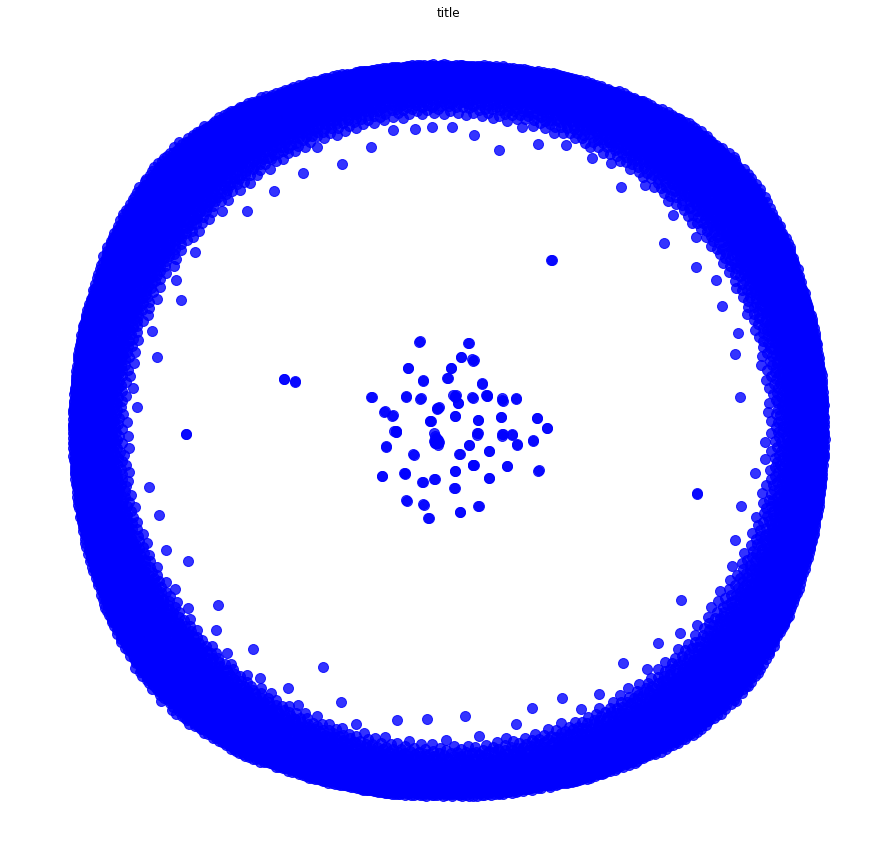

In [13]:
# REFERENCES GRAPH
fig = plt.figure(figsize=(15,15))
plt.axis('off')
plt.title('title')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,
                       node_color='b',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(G,pos,alpha=0.3)

In [14]:
# Number of links in the refrences graph
G.size()

106

In the network of publications, we barely can see any link. This is due to the small number of links: 106 for 10000 nodes and can be explained by the fact that 4183 from 10000 values are missing in the references. That's why we will do our best to come with a solution for that and will try to complete the missing data. 

### 2.1.b The network of authors

In [15]:
# Create list of all authors
authors=[]
for i in tqdm(range(len(info_df))):
    if type(info_df['authors'][i]) == str:
        authors.append(info_df['authors'][i])
    else:
        for author in info_df['authors'][i]:
            authors.append(author)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6897.17it/s]


In [16]:
# Remove all duplicates from list 
authors=list(set(authors))
authors.remove('')

In [17]:
authors_df=pd.DataFrame()
authors_df['name']=authors

In [18]:
# Add collborators to the authors dataframe
authors_df['collaborations']=""
for i in tqdm(range(len(info_df))):
    for author in info_df['authors'][i]:
        if type(info_df['authors'][i]) == str: continue
        else:
            if(type(authors_df['collaborations'][authors_df['name'][authors_df['name']==author].index])!=list):
                auth_list = list(authors_df['collaborations'][authors_df['name'][authors_df['name']==author].index])
                try: auth_list.remove('') 
                except ValueError: print('error')
            else:
                auth_list = authors_df['collaborations'][authors_df['name'][authors_df['name']==author].index]
                try: auth_list.remove('') 
                except ValueError: print('error')
            add_list= list(set(info_df['authors'][i]) - set([author]))
            for new in add_list:
                if new not in auth_list:
                    auth_list.append(new)
            authors_df['collaborations'][authors_df['name'].loc[authors_df['name']==author].index]=[auth_list]

 52%|██████████████████████████████████████████                                       | 52/100 [00:01<00:01, 31.80it/s]

error


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.81it/s]


In [19]:
# Create Graph for authors
A=nx.Graph()
A.add_nodes_from(authors_df['name'])
for i in range(len(authors_df)):
    for author in authors_df['collaborations'][i]:
        author=''.join(author)
        if(A.has_edge(authors_df['name'][i],author)): continue
        A.add_edge(authors_df['name'][i],author)

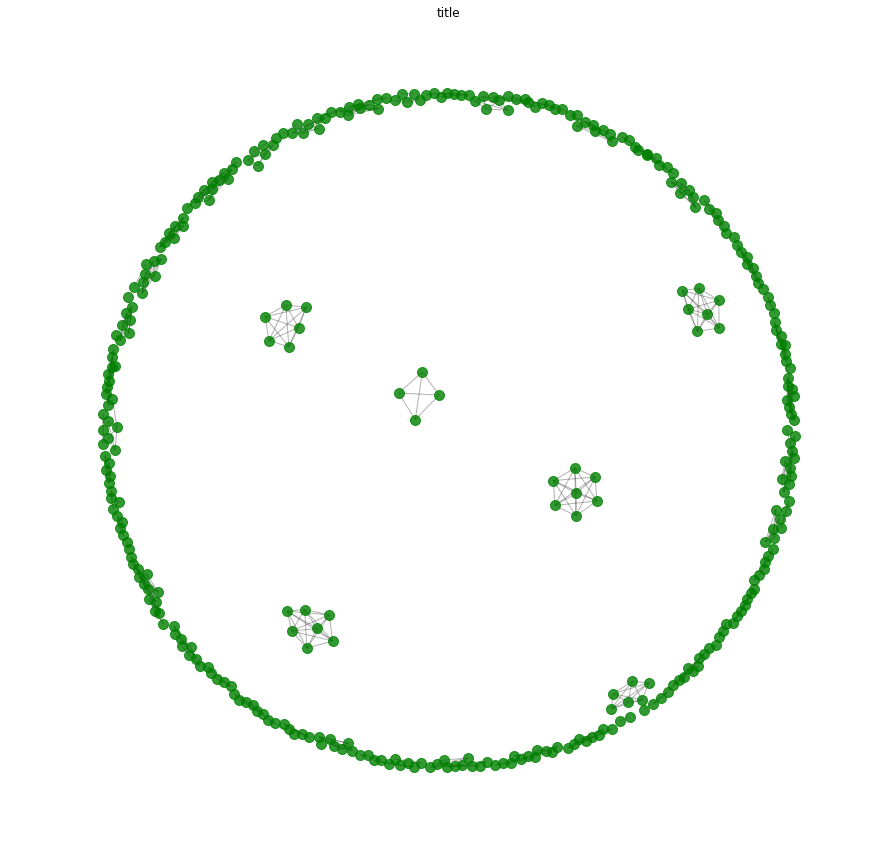

In [20]:
# Visualize Graph of authors
fig = plt.figure(figsize=(15,15))
plt.axis('off')
plt.title('title')
pos = nx.spring_layout(A)
nx.draw_networkx_nodes(A,pos,
                       node_color='g',
                       node_size=100,
                   alpha=0.8)
nx.draw_networkx_edges(A,pos,alpha=0.3)

## 2.2 Community Detection  
For the community detection, we used here as an example the Louvain method for community detection in order to get the graph partitions of communities. The algorithm is based on modularity optimization and has a time complexity of $ O(n.log n)$. Modularity is actually a measure for the density of edges inside communities to edges outside communities. Optimizing this value results in getting better grouping of communities in the network.

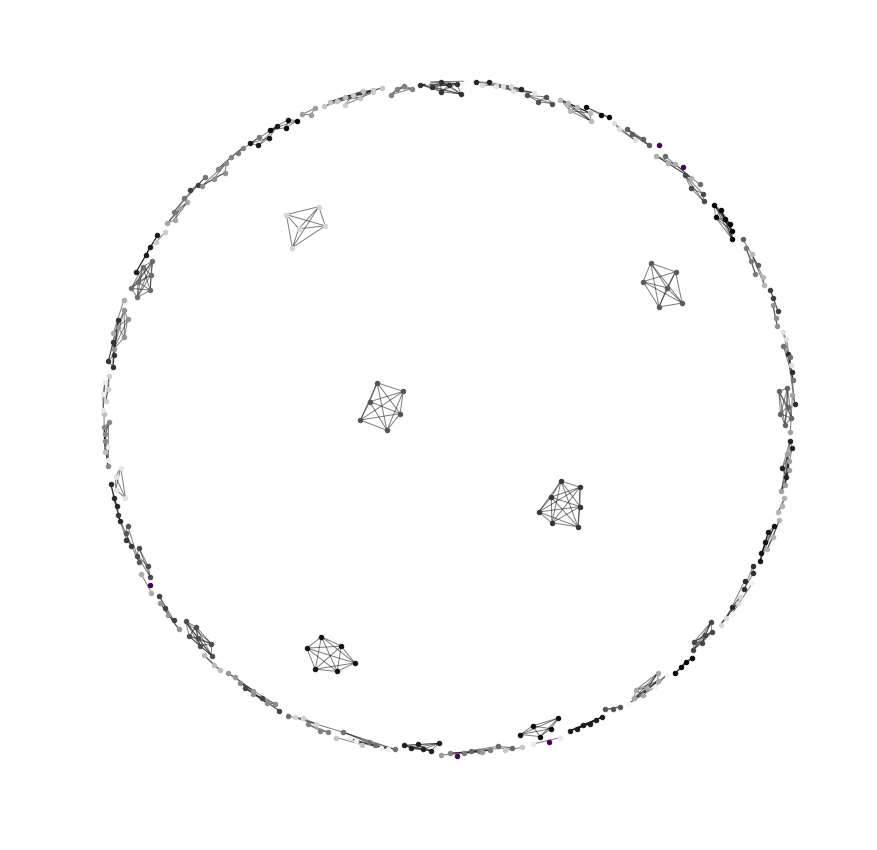

In [23]:
# Compute the best partition based on the Louvain method
partition = community.best_partition(A)

# Visualize the graph with the best partitioning
fig = plt.figure(figsize=(15,15))
plt.axis('off')
size = float(len(set(partition.values())))
pos = nx.spring_layout(A)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(A, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(A,pos, alpha=0.5)
plt.show()

## 2.3 Keyword Extraction  
As there is no information on the keywords of a certain paper, it is very important to extract the keywords using some text and natural language processsing algorithms such as Rapid Automatic Keyword Extraction aka RAKE which can be used as in the following example to help extract the keywords of the first paper

In [25]:
# Read the list of stopwords and extract the keywords of the com
Rake = RAKE.Rake('SmartStoplist.txt'); #takes stopwords as list of strings
Rake.run(df['abstract'][0]+' '+df['title'][0])

[('integrated arm cortex-a9 processor', 23.0),
 ('consuming fewer hardware resources', 14.833333333333334),
 ('architecture achieves higher performance', 13.333333333333334),
 ('real-time face detection', 13.266666666666667),
 ('standalone cortex-a9', 11.0),
 ('fpga hardware resources', 9.833333333333334),
 ('real-time applications', 9.666666666666668),
 ('real-time detection', 9.266666666666667),
 ('achieves high accuracy', 9.0),
 ('massive computing power', 9.0),
 ('xilinx zc702 platform', 9.0),
 ('experiment result shows', 9.0),
 ('dedicated hardware solutions', 8.833333333333334),
 ('prior-art implementation', 8.5),
 ('accelerator unit combination', 8.25),
 ('adaboost algorithm based', 8.0),
 ('cascaded classifiers involved', 8.0),
 ('accelerator achieves', 5.25),
 ('dedicated accelerator', 4.75),
 ('object detection', 4.6),
 ('adaboost detection', 4.6),
 ('objects detection', 4.6),
 ('opencv implementation', 4.5),
 ('heterogeneous architecture', 4.333333333333334),
 ('accelerator 

# 3. Conclusions & Plan for Milestone 3

**Conclusion:** the original dataset contains many inconsistencies in the data that need to be handled. It turns out that it is very hard to get the actual affliation of every author due to the fact that many informations that are online are not very up-to-date. The community detection and keyword extraction are far-reaching tasks that seem to be feasible on the tested sample and be applied on the complete dataset for the final submission. 

**Plan:** For the next Milestone, we plan to finish the following tasks and scale the examples of this notebook on the complete dataset

* Complete the data acquisition by completing the missing values and adding more informations on the papers as well as the authors using the DBLP API and the CrossRef API.
* Complete the graph analysis by computing basic graph measures(Degree Distributions, Clustering Coefficient) and centrality measure(Betweenness Centrality, Page-Rank/HITS)
* Find the communities in both netwokrs(publications and authors)
* Extract the keywords of the papers and then apply clustering algorithms based on these
* Match the found communities with the clusters

Since the computations take very long on our local machines (The network of publications has over 25 millions links and a total size of 4 Gb), we would like to use the cluster for more efficiency 